## Dataset import

In [1]:
import tensorflow as tf
import os
import jax
import numpy as np
import sys
import wandb
import jax.numpy as jnp
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from jax.lib import xla_bridge
from galsim_jax.datasets import cosmos
from flax import linen as nn  # Linen API

from galsim_jax.dif_models import AutoencoderKLModule
from galsim_jax.utils import (
    load_checkpoint_wandb,
    plot_examples,
    get_git_commit_version,
)
from galsim_jax.convolution import convolve_kpsf
from galsim_jax.nf_models import (
    encode,
    decode,
    NeuralSplineFlowLogProb,
    NeuralSplineFlowSampler,
)

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = str('2')
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-12.1"
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

# Checking for GPU access
print("Device: {}".format(xla_bridge.get_backend().platform))

# Checking the GPU available
gpus = jax.devices("gpu")
print("Number of avaliable devices : {}".format(len(gpus)))

# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type="GPU")

2023-09-29 13:10:36.883091: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-29 13:10:36.931078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 13:10:37.826443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Device: gpu
Number of avaliable devices : 1


In [2]:
# Loading the dataset and transforming it to NumPy Arrays
train_dset, info = tfds.load(name='Cosmos/25.2', with_info=True, split="train")

# What's in our dataset:
# info

def input_fn(mode="train", batch_size=32):
    """
    mode: 'train' or 'test'
    """

    def preprocess_image(data):
        # Reshape 'psf' and 'image' to (128, 128, 1)
        data["kpsf_real"] = tf.expand_dims(data["kpsf_real"], axis=-1)
        data["kpsf_imag"] = tf.expand_dims(data["kpsf_imag"], axis=-1)
        data["image"] = tf.expand_dims(data["image"], axis=-1)
        return data

    if mode == "train":
        dataset = tfds.load('Cosmos/25.2', split="train")
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load('Cosmos/25.2', split="test")

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(preprocess_image)  # Apply data preprocessing
    dataset = dataset.prefetch(
        -1
    )  # fetch next batches while training current one (-1 for autotune)
    return dataset

# Dataset as a numpy iterator
dset = input_fn().as_numpy_iterator()

## Initializing the autoencoder

In [3]:
# Generating a random key for JAX
rng, rng_2 = jax.random.PRNGKey(0), jax.random.PRNGKey(1)
# Size of the input to initialize the encoder parameters
batch_autoenc = jnp.ones((1, 128, 128, 1))

latent_dim = 128
act_fn = nn.gelu

# Initializing the AutoEncoder
Autoencoder = AutoencoderKLModule(
    ch_mult=(1, 2, 4, 8, 16),
    num_res_blocks=3,
    double_z=True,
    z_channels=1,
    resolution=latent_dim,
    in_channels=1,
    out_ch=1,
    ch=1,
    embed_dim=1,
    act_fn=act_fn,
)

params_auto = Autoencoder.init(rng, x=batch_autoenc, seed=rng_2)

x : (1, 128, 128, 1)
Conv_in : (1, 128, 128, 1)
Down : (1, 8, 8, 16)
Mid : (1, 8, 8, 16)
Conv_out : (1, 8, 8, 2)
Moments shape : (1, 8, 8, 2)
Posterior : tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[1, 8, 8], event_shape=[1], dtype=float32)
Working with z of shape (1, 1, 8, 8) = 64 dimensions.


In [4]:
# Login to wandb
wandb.login()

# Initializing a Weights & Biases Run
wandb.init(
    project='NF-results',
    name='exp-6',
)

# Setting the configs of our experiment using `wandb.config`.
# This way, Weights & Biases automatically syncs the configs of
# our experiment which could be used to reproduce the results of an experiment.
config = wandb.config
config.commit_version = get_git_commit_version()

wandb: Currently logged in as: jonnyytorres. Use `wandb login --relogin` to force relogin


## Downloading checkpoint from Wandb

In [5]:
api = wandb.Api()

In [6]:
run = api.run("jonnyytorres/VAE-SD-NewELBO/ypziyp89")

artifact = api.artifact('jonnyytorres/VAE-SD-NewELBO/ypziyp89-checkpoint:best', type='model')
artifact_dir = artifact.download()

# Loading checkpoint for the best step
params_auto = load_checkpoint_wandb(run.id, "checkpoint.msgpack", params_auto)

wandb:   1 of 1 files downloaded.  


## Defining the encoder from the AutoEncoder module

In [7]:
enc = encode(ch_mult=(1, 2, 4, 8, 16),
    num_res_blocks=3,
    double_z=True,
    z_channels=1,
    resolution=latent_dim,
    in_channels=1,
    out_ch=1,
    ch=1,
    embed_dim=1,
    act_fn=act_fn)

In [8]:
# Iterating over the TFDS dataset
dataset_eval = input_fn("train")
test_iterator = dataset_eval.as_numpy_iterator()
batch = next(test_iterator)

# Taking a batch of images
x = batch["image"]

In [9]:
posterior = enc.apply(params_auto, x)

x : (32, 128, 128, 1)
Conv_in : (32, 128, 128, 1)
Down : (32, 8, 8, 16)
Mid : (32, 8, 8, 16)
Conv_out : (32, 8, 8, 2)
Moments shape : (32, 8, 8, 2)
Posterior : tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[32, 8, 8], event_shape=[1], dtype=float32)


In [10]:
rng, rng_2 = jax.random.split(rng_2)

z = posterior.sample(seed=rng)

# Converting array into float32
z_ = np.float32(z)

In [11]:
z_.shape

(32, 8, 8, 1)

In [12]:
@jax.jit
def encode(params, x):
  return enc.apply(params, x)

In [13]:
for i in range(624):
    # batch of dataset
    batch = next(test_iterator)

    # Taking a batch of images
    x = batch["image"]

    # Estimating the posterior by using the encoder
    posterior = encode(params_auto, x)

    # Generating a new pseudo-random key
    rng, rng_2 = jax.random.split(rng_2)

    # Sampling over the posterior
    z2 = posterior.sample(seed=rng)
    
    # Converting array into float32
    z2 = np.float32(z2)

    # Appending to existing array
    z_ = np.append(z_, z2, axis=0)
    
# Veryfing the shape of the final array
z_.shape

x : (32, 128, 128, 1)
Conv_in : (32, 128, 128, 1)
Down : (32, 8, 8, 16)
Mid : (32, 8, 8, 16)
Conv_out : (32, 8, 8, 2)
Moments shape : (32, 8, 8, 2)
Posterior : tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[32, 8, 8], event_shape=[1], dtype=float32)


(20000, 8, 8, 1)

In [14]:
z_ = z_.reshape(20000,64)

In [15]:
z_.shape

(20000, 64)

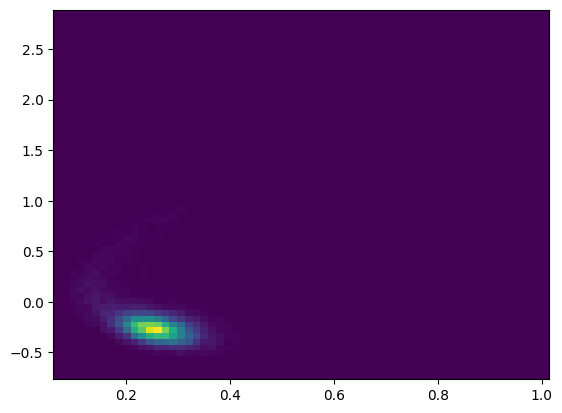

In [16]:
plt.hist2d(z_[:,0], z_[:,1], 64);

<Figure size 1450x800 with 0 Axes>

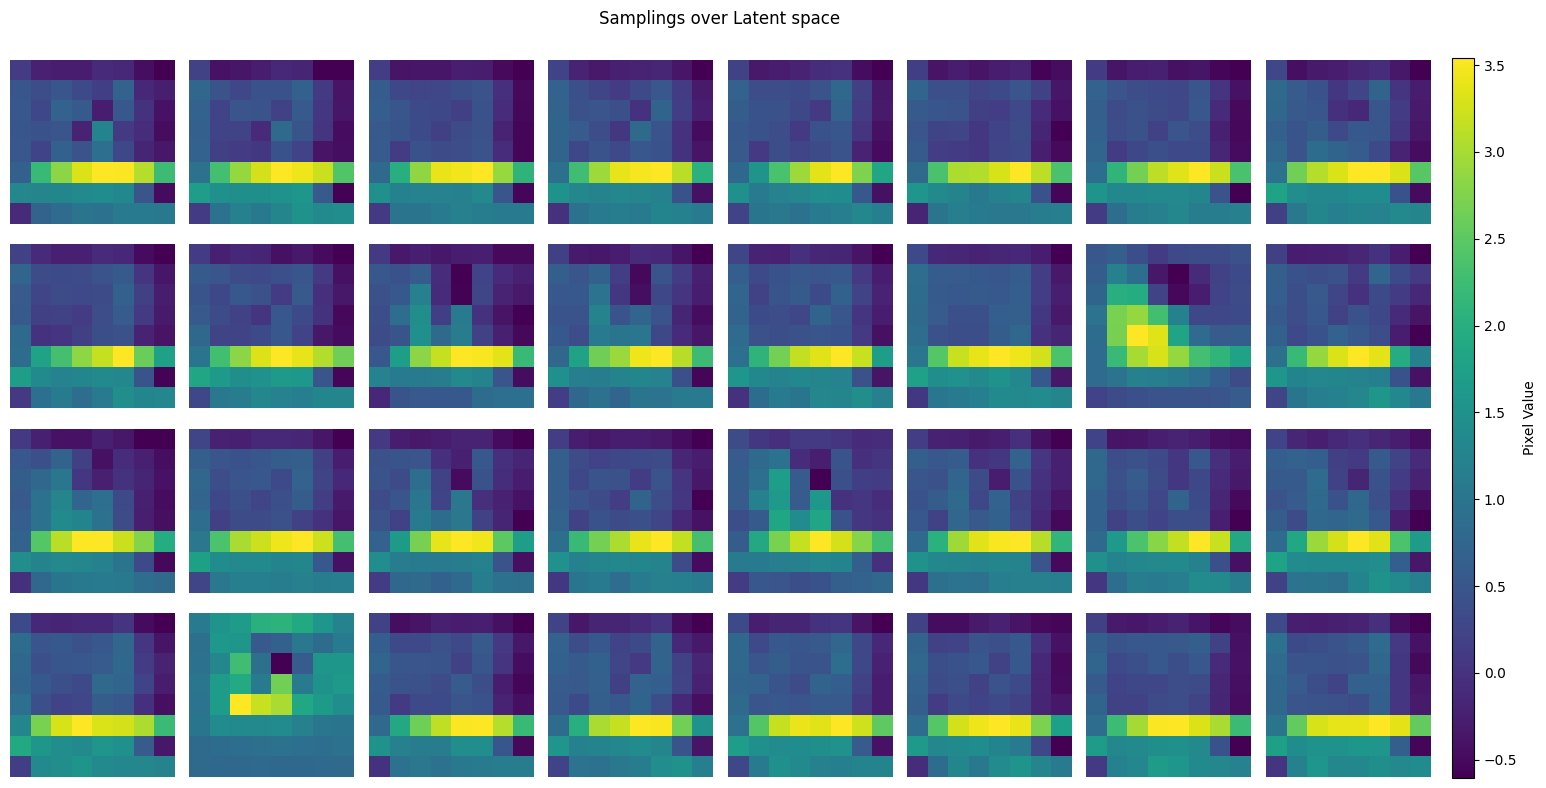

In [17]:
import matplotlib.pyplot as plt

# Plotting the original, predicted and their differences for 8 examples
num_rows, num_cols = 4, 8

plt.figure(figsize=(14.5, 8))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14.5, 8))

for ax, z_img in zip(axes.flatten(), z):
    ax.imshow(z_img)
    ax.axis("off")

# Add a title to the figure
fig.suptitle("Samplings over Latent space", fontsize=12, y=0.99)

# Adjust the layout of the subplots
fig.tight_layout()

cb_ax = fig.add_axes([1.005,.03,.015,.90])
fig.colorbar(ax.imshow(z_img),label="Pixel Value", orientation="vertical", cax=cb_ax) #,ax=axes.ravel().tolist())

# plt.savefig('Original_FR_galaxies_2.png')
# plt.close(fig)

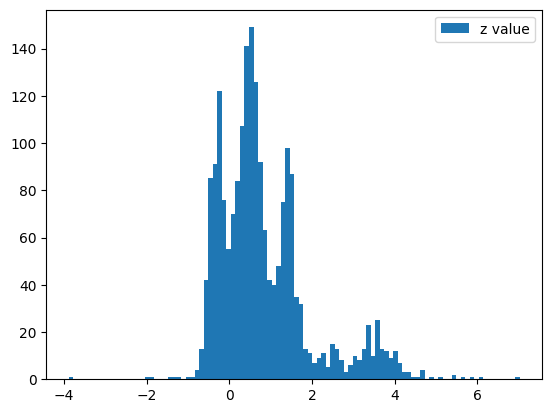

In [18]:
# Histogram of z values
plt.hist(z.flatten(),100, label='z value');
plt.legend();

<Figure size 1450x800 with 0 Axes>

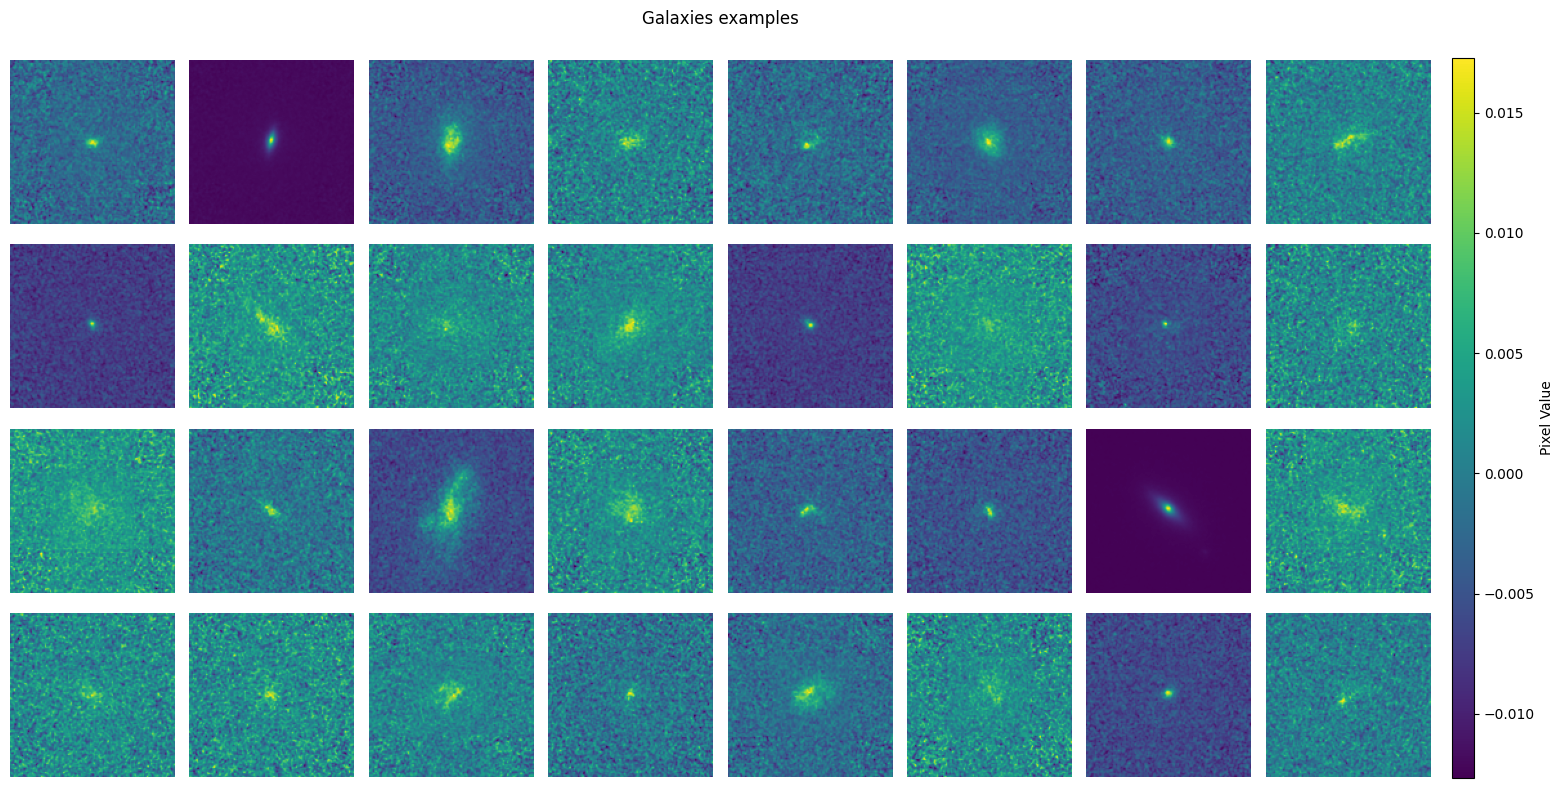

In [19]:
# Taking a bunch of images 
batch = next(dset)
x = batch['image']

# Plotting the original, predicted and their differences for 8 examples
num_rows, num_cols = 4, 8

plt.figure(figsize=(14.5, 8))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14.5, 8))

for ax, z_img in zip(axes.flatten(), x):
    ax.imshow(z_img)
    ax.axis("off")

# Add a title to the figure
fig.suptitle("Galaxies examples", fontsize=12, y=0.99)

# Adjust the layout of the subplots
fig.tight_layout()

cb_ax = fig.add_axes([1.005,.03,.015,.90])
fig.colorbar(ax.imshow(z_img),label="Pixel Value", orientation="vertical", cax=cb_ax) #,ax=axes.ravel().tolist())

# plt.savefig('Original_FR_galaxies_2.png')
# plt.close(fig)

## Testing the decoder

In [20]:
dec = decode(ch_mult=(1, 2, 4, 8, 16),
    num_res_blocks=3,
    double_z=True,
    z_channels=1,
    resolution=latent_dim,
    in_channels=1,
    out_ch=1,
    ch=1,
    embed_dim=1,
    act_fn=act_fn)

In [21]:
x_galaxie = dec.apply(params_auto, z)

kpsf_real = batch["kpsf_real"]
kpsf_imag = batch["kpsf_imag"]
kpsf = kpsf_real + 1j * kpsf_imag
std = batch["noise_std"].reshape((-1, 1, 1, 1))

# Converting array into float32
std = np.float32(std)

# Generating a random key for JAX
rng, rng_2 = jax.random.PRNGKey(0), jax.random.PRNGKey(1)

rng, rng_1 = jax.random.split(rng)
# X estimated distribution

x_convolve_ = jax.vmap(convolve_kpsf)(x_galaxie[..., 0], kpsf[..., 0])

x_convolve_ = tf.expand_dims(x_convolve_, axis=-1)

Working with z of shape (1, 1, 8, 8) = 64 dimensions.


In [22]:
x_galaxie.shape

(32, 128, 128, 1)

<Figure size 1450x800 with 0 Axes>

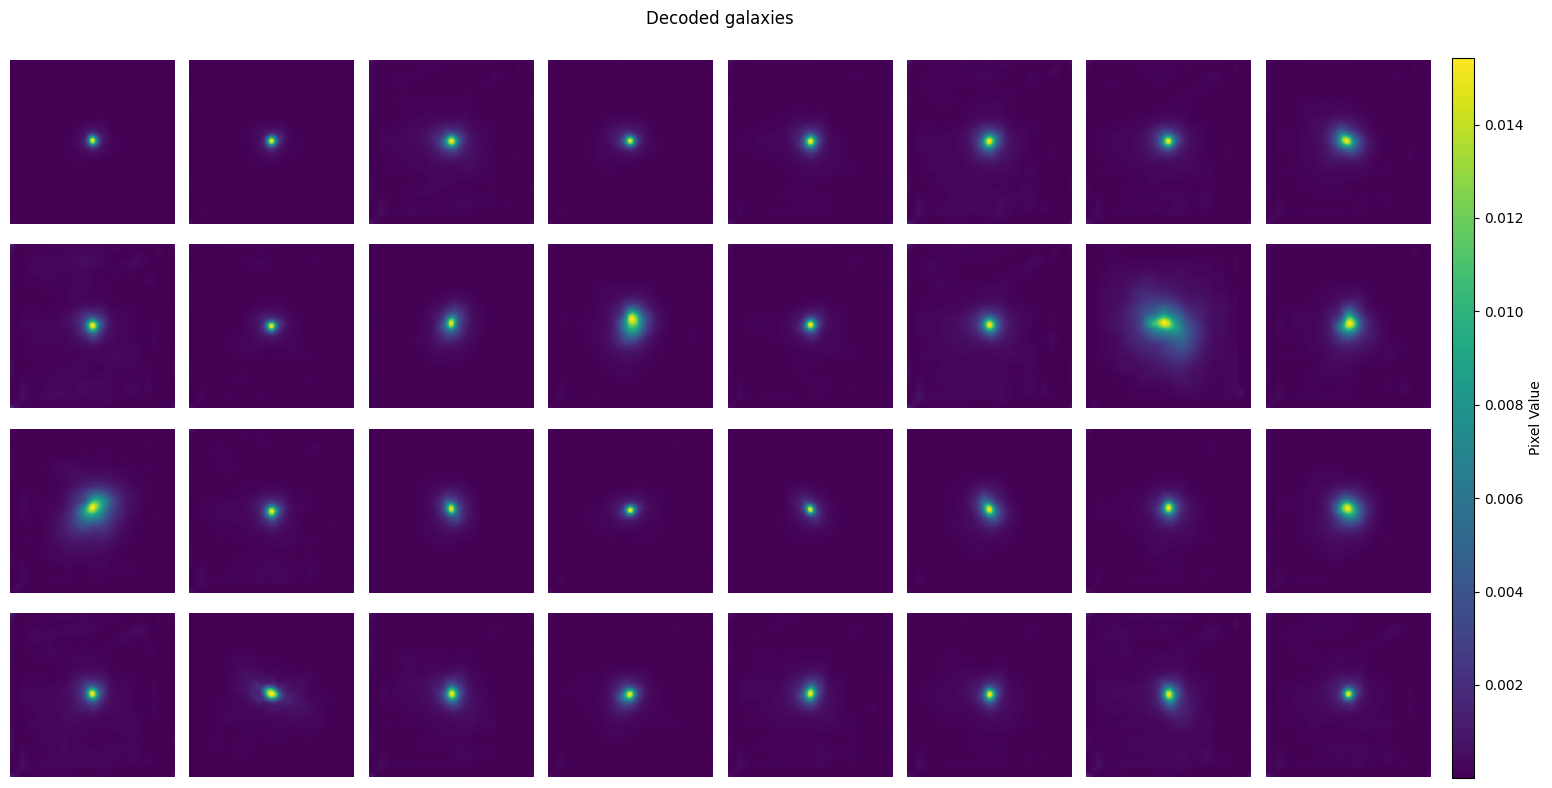

In [23]:
# Plotting the original, predicted and their differences for 8 examples
num_rows, num_cols = 4, 8

plt.figure(figsize=(14.5, 8))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14.5, 8))

for ax, z_img in zip(axes.flatten(), x_convolve_):
    ax.imshow(z_img)
    ax.axis("off")

# Add a title to the figure
fig.suptitle("Decoded galaxies", fontsize=12, y=0.99)

# Adjust the layout of the subplots
fig.tight_layout()

cb_ax = fig.add_axes([1.005,.03,.015,.90])
fig.colorbar(ax.imshow(z_img),label="Pixel Value", orientation="vertical", cax=cb_ax) #,ax=axes.ravel().tolist())

## Normalizing Flow

In [24]:
# Calling the NF model
model = NeuralSplineFlowLogProb()

# Random seed for initializing network and sampling training data
seed = jax.random.PRNGKey(42)

# Initializes the weights of the model
params_nf = model.init(seed, jnp.zeros((1, 64)))

# Calling the NF Sampler
sampler = NeuralSplineFlowSampler()

# Obtaining the id for the best NF experiment
id_run = "53oggvli"

# Downloading best checkpoint params
run = api.run("jonnyytorres/NF_experiments/{}".format(id_run))
artifact = api.artifact(
    "jonnyytorres/NF_experiments/{}-checkpoint:best".format(id_run), type="model"
)
artifact_dir = artifact.download()

# Loading checkpoint for the best step
params_nf = load_checkpoint_wandb(run.id, "checkpoint.msgpack", params_nf)

/local/home/jt275011/.local/lib/python3.8/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:285: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)
wandb:   1 of 1 files downloaded.  


## Testing the sampler

In [25]:
sampler = NeuralSplineFlowSampler()

In [26]:
# Downloading best checkpoint params
run = api.run("jonnyytorres/NF_experiments/{}".format(id_run))
artifact = api.artifact('jonnyytorres/NF_experiments/{}-checkpoint:best'.format(id_run), type='model') 
artifact_dir = artifact.download()

# Loading checkpoint for the best step
params_nf = load_checkpoint_wandb(run.id, "checkpoint.msgpack", params_nf)

wandb:   1 of 1 files downloaded.  


In [27]:
samps = sampler.apply(params_nf, jax.random.PRNGKey(1), 20000)

In [28]:
samps.shape

(20000, 64)

In [29]:
samps.mean()

Array(0.8412191, dtype=float32)

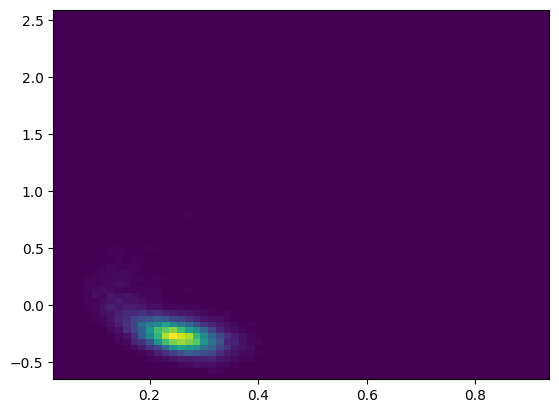

In [30]:
plt.hist2d(samps[:,0], samps[:,1],64);

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_2_histograms(data1_x, data1_y, data2_x, data2_y):

    # Plot the histograms as heatmaps
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist2d(data1_x, data1_y, bins=64)
    plt.title('Distribution of samples of original z')
    
    plt.subplot(1, 2, 2)
    plt.hist2d(data2_x, data2_y, bins=64)
    plt.title('Distribution of samples of estimated z')
    
    # plt.colorbar()
    plt.show()

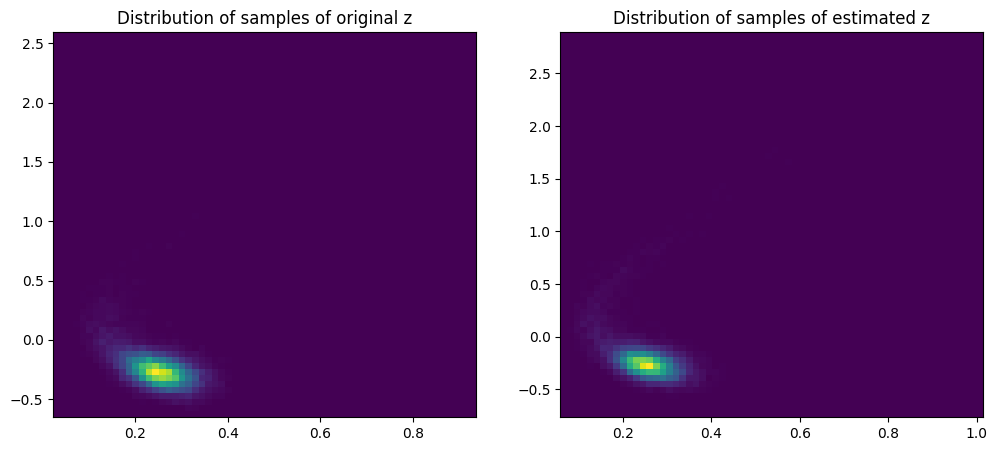

In [32]:
plot_2_histograms(samps[:,0], samps[:,1], z_[:,0], z_[:,1])

In [33]:
samps = sampler.apply(params_nf, jax.random.PRNGKey(1), 32)

In [34]:
# Resahping to original bottleneck size
samps_r = samps.reshape(-1,8,8,1)

In [35]:
samps_r.shape

(32, 8, 8, 1)

## Using the decoder to reconstruct the galaxy images

In [36]:
q_nf = dec.apply(params_auto, samps_r)

Working with z of shape (1, 1, 8, 8) = 64 dimensions.


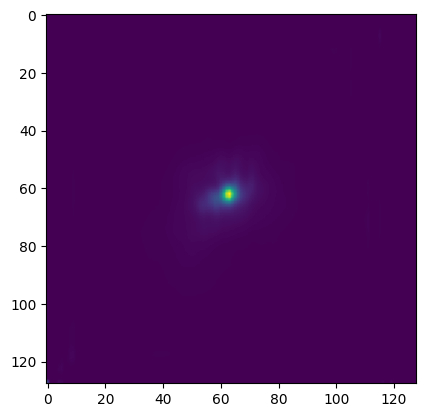

In [37]:
# Example of a sampled galaxy before the convolution with the PSF 
plt.imshow(q_nf[0,...,0])

In [38]:
q_nf[...,-1].shape

(32, 128, 128)

In [39]:
kpsf_real = batch["kpsf_real"]
kpsf_imag = batch["kpsf_imag"]
kpsf = kpsf_real + 1j * kpsf_imag
std = batch["noise_std"].reshape((-1, 1, 1, 1))

# Converting array into float32
std = np.float32(std)

# Generating a random key for JAX
rng, rng_2 = jax.random.PRNGKey(0), jax.random.PRNGKey(1)

rng, rng_1 = jax.random.split(rng)
# X estimated distribution

x_convolve = jax.vmap(convolve_kpsf)(q_nf[..., 0], kpsf[..., 0])

x_convolve = tf.expand_dims(x_convolve, axis=-1)

# z3 = x_convolve

# p3 = tfd.MultivariateNormalDiag(loc=p3, scale_diag=[0.01])


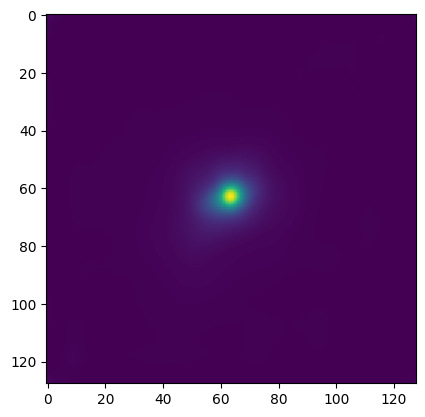

In [40]:
# Example of a sampled galaxy after the convolution with the PSF 
plt.imshow(x_convolve[0,...,0])

<Figure size 1450x800 with 0 Axes>

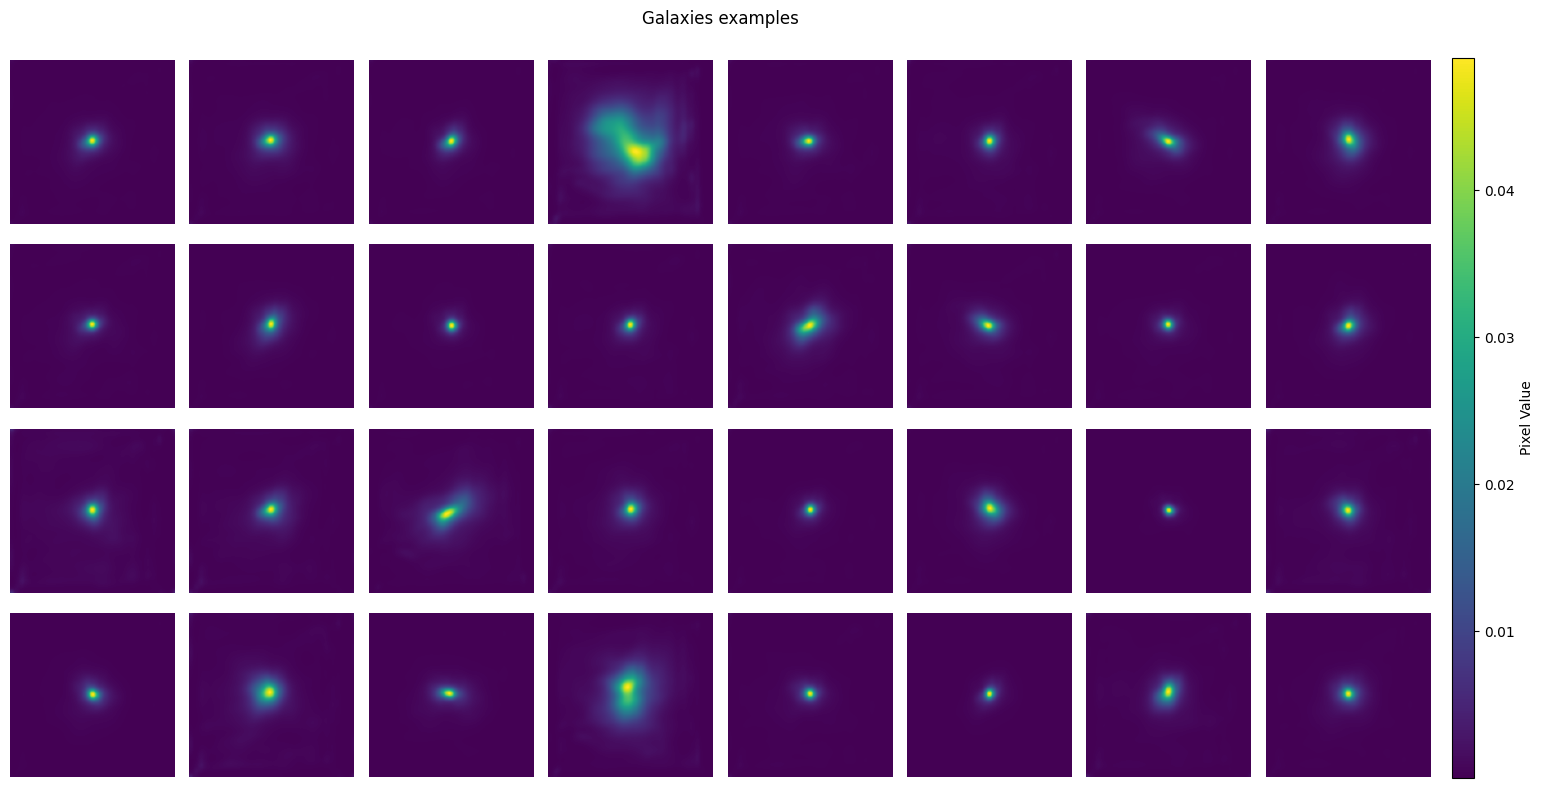

In [41]:
# Plotting the original, predicted and their differences for 32 examples
num_rows, num_cols = 4, 8

plt.figure(figsize=(14.5, 8))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14.5, 8))

for ax, z_img in zip(axes.flatten(), x_convolve):
    ax.imshow(z_img)
    ax.axis("off")

# Add a title to the figure
fig.suptitle("Galaxies examples", fontsize=12, y=0.99)

# Adjust the layout of the subplots
fig.tight_layout()

cb_ax = fig.add_axes([1.005,.03,.015,.90])
fig.colorbar(ax.imshow(z_img),label="Pixel Value", orientation="vertical", cax=cb_ax) #,ax=axes.ravel().tolist())

wandb.log({'reconstructed_galaxies': wandb.Image(plt)})

In [42]:
wandb.finish()

In [43]:
import galsim

STAMP_SIZE = 128
PIXEL_SCALE = 0.03

# Loads COSMOS sample
cosmos_cat = galsim.COSMOSCatalog()

# Noise model
cosmos_noise = galsim.getCOSMOSNoise()

In [44]:
# Converting array into float32
x_convolve_ = np.float32(x_convolve)

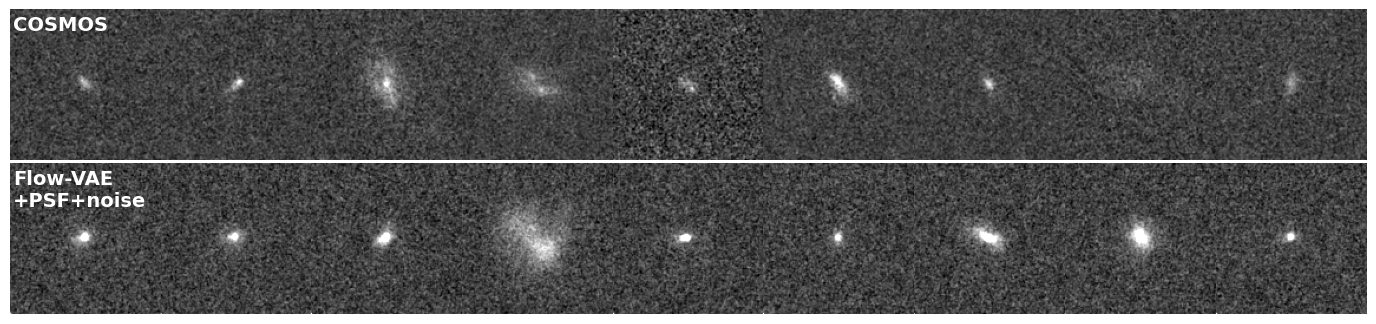

In [45]:
plt.figure(figsize=(17.5,4))
for i in range(9):
    im_real = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    im_sim = galsim.ImageF(np.float32(q_nf[i,...,0]), copy=True)
    im_sim_n = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    
    # Drawing galaxy from cosmos
    gal = cosmos_cat.makeGalaxy(i, gal_type='real', noise_pad_size=0.8*STAMP_SIZE*PIXEL_SCALE)
    psf = gal.original_psf
    real = galsim.Convolve(psf, gal)
    real.drawImage(im_real, method='no_pixel');
    
    # Drawing galaxy from generative model
    im_sim.addNoise(cosmos_noise)

    my_moments = im_sim.FindAdaptiveMom()

    # print(np.mean([my_moments.observed_shape.g1, my_moments.observed_shape.g2]), my_moments.moments_sigma)
    
    plt.subplot(2,9,i+1)
    plt.imshow(im_real.array, cmap='gray',vmin=-0.01,vmax=0.03)
    plt.axis('off')
    if i==0:
        plt.text(2, 5, "COSMOS", verticalalignment='top', fontsize=14, color="white", weight="bold")
    
    plt.subplot(2,9,i+1+9)
    plt.imshow(im_sim.array, cmap='gray',vmin=-0.01,vmax=0.03)   
    plt.axis('off')
    if i==0:
        plt.text(2, 5, "Flow-VAE\n+PSF+noise", verticalalignment='top', fontsize=14, color="white", weight="bold")

plt.subplots_adjust(wspace=0, hspace=0)
# savefig('Figures/Figure1.pdf',bbox_inches='tight')

In [46]:
all_moments = {'COSMOS' : 
               {
                   'mean_ellipcity' : [],
                   'determinant_radius' : [],
               },
               'MOCK' : 
               {
                   'mean_ellipcity' : [],
                   'determinant_radius' : [],
               }
              }

def galaxy_moments(galaxy_image):
    my_moments = galaxy_image.FindAdaptiveMom()
    moments = [np.mean([my_moments.observed_shape.g1, my_moments.observed_shape.g2]), my_moments.moments_sigma*PIXEL_SCALE]
    return moments

In [47]:
@jax.jit
def decode(params, x):
  return dec.apply(params, x)

In [48]:
num_errors = 0 

for i in range(626):
    # Another batch for the dataset
    batch = next(dset)

    # Taking 32 images
    x = batch['image']

    # Number of images
    num_images = x.shape[0]
    
    # Sampling 32 examples from the NF 
    samps = sampler.apply(params_nf, jax.random.PRNGKey(1), 32)
    
    # Resahping to original bottleneck size
    samps_r = samps.reshape(-1,8,8,1)
     
    # Estimating the original distribution by using the decoder
    q_nf = decode(params_auto, samps_r)

    # Taking the PSF parameters from the batch
    kpsf_real = batch["kpsf_real"]
    kpsf_imag = batch["kpsf_imag"]
    kpsf = kpsf_real + 1j * kpsf_imag
    
    # Convolving the estimated image with the PSF
    x_convolve = jax.vmap(convolve_kpsf)(q_nf[..., 0], kpsf[..., 0])

    # Adding the 'channels' dimension
    x_convolve = tf.expand_dims(x_convolve, axis=-1)

    x_convolve = np.float32(x_convolve)

    for j in range(num_images):
        try:
            # Calculating moments for simulated images
            im_sim = galsim.ImageF((x_convolve[j,...,0]), copy=True)
            im_sim.addNoise(cosmos_noise)
            all_moments['MOCK']['mean_ellipcity'].append(galaxy_moments(im_sim)[0])
            all_moments['MOCK']['determinant_radius'].append(galaxy_moments(im_sim)[1])
            
            # Calculating moments for COSMOS images
            im_real = galsim.ImageF(x[j,...,0], copy=True)
            im_real.addNoise(cosmos_noise)
            all_moments['COSMOS']['mean_ellipcity'].append(galaxy_moments(im_real)[0])
            all_moments['COSMOS']['determinant_radius'].append(galaxy_moments(im_real)[1])
        except:
            num_errors +=1
            print("Something went wrong doing the for cycle, number of errors = {}, cycle = {}".format(num_errors, i*32+j))


/local/home/jt275011/.local/lib/python3.8/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:285: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


Working with z of shape (1, 1, 8, 8) = 64 dimensions.
Something went wrong doing the for cycle, number of errors = 1, cycle = 112
Something went wrong doing the for cycle, number of errors = 2, cycle = 188
Something went wrong doing the for cycle, number of errors = 3, cycle = 211
Something went wrong doing the for cycle, number of errors = 4, cycle = 290
Something went wrong doing the for cycle, number of errors = 5, cycle = 343
Something went wrong doing the for cycle, number of errors = 6, cycle = 364
Something went wrong doing the for cycle, number of errors = 7, cycle = 419
Something went wrong doing the for cycle, number of errors = 8, cycle = 547
Something went wrong doing the for cycle, number of errors = 9, cycle = 657
Something went wrong doing the for cycle, number of errors = 10, cycle = 677
Something went wrong doing the for cycle, number of errors = 11, cycle = 770
Something went wrong doing the for cycle, number of errors = 12, cycle = 779
Something went wrong doing the 

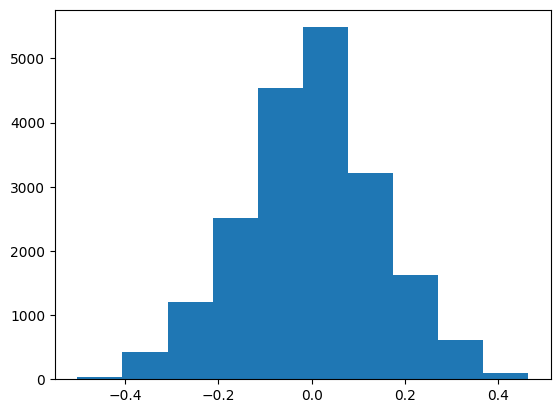

In [49]:
plt.hist(all_moments['COSMOS']['mean_ellipcity']);

In [50]:
len(all_moments['COSMOS']['mean_ellipcity'])

19761

In [56]:
import seaborn as sns

sns.set()
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})

creal = plt.cm.viridis(0.1)
cmock = plt.cm.viridis(0.35)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# plt.figure(figsize=(10,4))
plt.subplot(121)

sns.distplot(all_moments['COSMOS']['mean_ellipcity'], label='COSMOS', hist=False, color=creal);
# plt.axvline(np.mean(all_moments['COSMOS']['mean_ellipcity']), color=creal)
sns.distplot(all_moments['MOCK']['mean_ellipcity'], label='Model', hist=False, color=cmock);
# plt.axvline(np.mean(all_moments['MOCK']['mean_ellipcity']), color=cmock)
plt.xlim(0,0.8)
plt.legend()
plt.xlabel('Ellipticity $g$')
# print("Mean real ellipticity: %0.4f +/- %0.4f"%(np.mean(all_moments['COSMOS']['mean_ellipcity'])),
#                                                 sem(all_moments['COSMOS']['mean_ellipcity']))
# print("Mean mock ellipticity: %0.4f +/- %0.4f"%(np.mean(all_moments['MOCK']['mean_ellipcity'])),
#                                                 sem(all_moments['MOCK']['mean_ellipcity']))

plt.subplot(122)
sns.distplot(all_moments['COSMOS']['determinant_radius'], label='COSMOS', hist=False, color=creal);
# plt.axvline(np.mean(all_moments['COSMOS']['determinant_radius']*res), color=creal)
sns.distplot(all_moments['MOCK']['determinant_radius'], label='Model', hist=False, color=cmock);
# plt.axvline(np.mean(all_moments['MOCK']['determinant_radius']*res), color=cmock)
plt.legend()
plt.xlabel('Determinant radius [arcsec]')
plt.xlim(0.05,0.6);
# print("Mean real size: %0.4f +/-%0.4f"%(np.mean(all_moments['COSMOS']['determinant_radius']*res),
#                                                 sem(all_moments['COSMOS']['determinant_radius']*res)))
# print("Mean mock size: %0.4f +/-%0.4f"%(np.mean(all_moments['MOCK']['determinant_radius']*res),
#                                                 sem(all_moments['MOCK']['determinant_radius']*res)))

# Adjust the layout of the subplots
fig.tight_layout()

plt.savefig('Model_moments.png')
plt.close(fig)

/tmp/ipykernel_3811828/2442703480.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_moments['COSMOS']['mean_ellipcity'], label='COSMOS', hist=False, color=creal);
/tmp/ipykernel_3811828/2442703480.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_moments['MOCK']['